# Raster CRUD operations with the Geospatial API

In [1]:
import os
import rasterio
from rasterio.io import MemoryFile
from matplotlib import pyplot
from cognite.client.data_classes.geospatial import *
from cognite.client import ClientConfig, CogniteClient
from cognite.client.credentials import OAuthClientCredentials

In [2]:
credentials = OAuthClientCredentials(
    token_url=os.environ["COGNITE_TOKEN_URL"],
    client_id=os.environ["COGNITE_CLIENT_ID"],
    client_secret=os.environ["COGNITE_CLIENT_SECRET"],
    scopes=os.environ["COGNITE_TOKEN_SCOPES"].split(","),
)
client = CogniteClient(ClientConfig(
        client_name=os.environ["COGNITE_CLIENT_NAME"],
        project=os.environ["COGNITE_PROJECT"],
        base_url=os.environ["COGNITE_BASE_URL"],
        credentials=credentials,
    ))

### Cleanup

In [3]:
try:
    client.geospatial.delete_feature_types(external_id="rasters", recursive=True)
except:
    pass

## The raster input data

Data is extracted from "1:50m Natural Earth II" (https://www.naturalearthdata.com/downloads/50m-raster-data/50m-natural-earth-2/)

### Geotiff

In [4]:
input_0412 = "../data/Natural_Earth/NE2_50M_SR_04_12.tif"

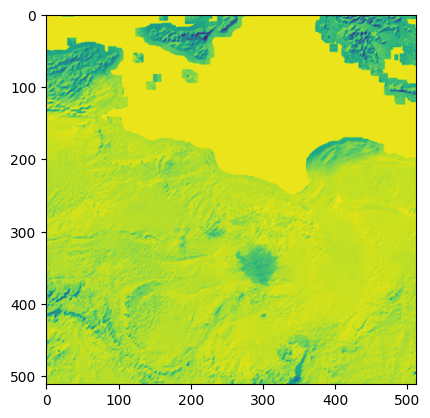

In [5]:
# NBVAL_IGNORE_OUTPUT
src = rasterio.open(input_0412)
pyplot.imshow(src.read(1))

### XYZ

In [6]:
input_0414 = "../data/Natural_Earth/NE2_50M_SR_04_14.xyz"

In [7]:
xyz = bytearray(open(input_0414, 'rb').read()).decode('utf-8')
for line in xyz.splitlines()[:10]:
    print(line)

41.88333333 38.78333333 166
41.91666667 38.78333333 166
41.95 38.78333333 175
41.98333333 38.78333333 204
42.01666667 38.78333333 227
42.05 38.78333333 232
42.08333333 38.78333333 234
42.11666667 38.78333333 229
42.15 38.78333333 213
42.18333333 38.78333333 198


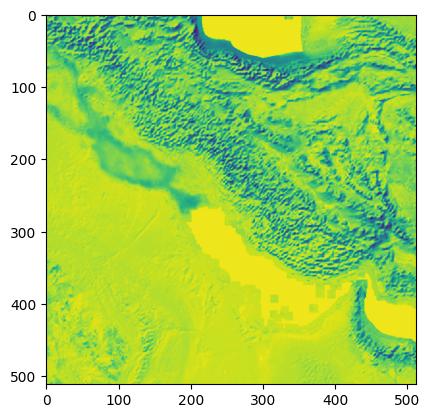

In [8]:
# NBVAL_IGNORE_OUTPUT
src = rasterio.open(input_0414).read(1)
pyplot.imshow(src)

## Create feature type with raster property

In [9]:
ft = client.geospatial.create_feature_types(
    FeatureType(
        external_id="rasters",
        properties={
            "raster": {"srid": 4326, "type": "RASTER", "storage": "embedded", "optional": True},
        }
    )
)

## Ingest the raster data (geotiff)

### Create a feature (geotiff)

In [10]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.create_features(
    feature_type_external_id="rasters",
    feature=Feature(external_id="ne0412"),
)

,value
external_id,ne0412
created_time,1664789530914
last_updated_time,1664789530914


### Push the raster (geotiff)

In [11]:
# NBVAL_IGNORE_OUTPUT
metadata = client.geospatial.put_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0412",
    raster_property_name="raster",
    raster_format="GTiff",
    raster_srid=4326,
    file=input_0412,
)
metadata.__dict__

{'cognite_client': <cognite.client._cognite_client.CogniteClient at 0x7ff73c121670>,
 'srid': 4326,
 'upper_left_x': 7.733333333314562,
 'upper_left_y': 38.80000000000511,
 'width': 512,
 'height': 512,
 'scale_x': 0.03333333333333,
 'scale_y': -0.03333333333333,
 'skew_x': 0.0,
 'skew_y': 0.0,
 'num_bands': 3}

### Create a feature (XYZ)

In [12]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.create_features(
    feature_type_external_id="rasters",
    feature=Feature(external_id="ne0414"),
)

,value
external_id,ne0414
created_time,1664789533005
last_updated_time,1664789533005


### Push the raster (XYZ)

In [13]:
# NBVAL_IGNORE_OUTPUT
metadata = client.geospatial.put_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0414",
    raster_property_name="raster",
    raster_format="XYZ",
    raster_srid=4326,
    file=input_0414,
)
metadata.__dict__

{'cognite_client': <cognite.client._cognite_client.CogniteClient at 0x7ff73c121670>,
 'srid': 4326,
 'upper_left_x': 41.86666666332681,
 'upper_left_y': 38.7999999966634,
 'width': 512,
 'height': 512,
 'scale_x': 0.03333333334637965,
 'scale_y': -0.03333333332681017,
 'skew_x': 0.0,
 'skew_y': 0.0,
 'num_bands': 1}

## Read operations

### Fetch raster metadata

In [14]:
f = client.geospatial.retrieve_features(feature_type_external_id="rasters", external_id="ne0412")
f.raster

{'srid': 4326,
 'upperLeftX': 7.733333333314562,
 'upperLeftY': 38.80000000000511,
 'width': 512,
 'height': 512,
 'scaleX': 0.03333333333333,
 'scaleY': -0.03333333333333,
 'skewX': 0.0,
 'skewY': 0.0,
 'numBands': 3}

In [15]:
f = client.geospatial.retrieve_features(feature_type_external_id="rasters", external_id="ne0414")
f.raster

{'srid': 4326,
 'upperLeftX': 41.86666666332681,
 'upperLeftY': 38.7999999966634,
 'width': 512,
 'height': 512,
 'scaleX': 0.03333333334637965,
 'scaleY': -0.03333333332681017,
 'skewX': 0.0,
 'skewY': 0.0,
 'numBands': 1}

### Fetch raster (geotiff)

(512, 512)


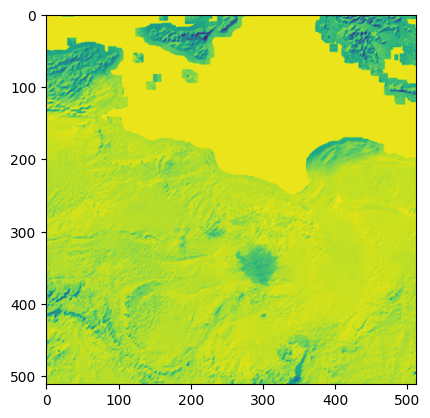

In [16]:
r = client.geospatial.get_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0412",
    raster_property_name="raster",
    raster_format="GTiff",
)

with MemoryFile(r) as memfile:
    with memfile.open() as dataset:
        print(dataset.shape)
        pyplot.imshow(dataset.read(1))

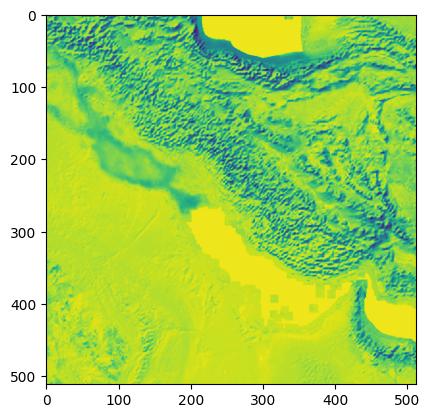

In [17]:
r = client.geospatial.get_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0414",
    raster_property_name="raster",
    raster_format="GTiff",
)

with MemoryFile(r) as memfile:
    with memfile.open() as dataset:
        pyplot.imshow(dataset.read(1))

### Fetch raster (XYZ) 

In [18]:
r = client.geospatial.get_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0414",
    raster_property_name="raster",
    raster_format="XYZ",
)

In [19]:
for line in r.decode('utf-8').splitlines()[0:10]:
    print(line)

41.8833333299999993 38.7833333299999978 166
41.9166666633463834 38.7833333299999978 166
41.9499999966927604 38.7833333299999978 175
41.9833333300391374 38.7833333299999978 204
42.0166666633855215 38.7833333299999978 227
42.0499999967318985 38.7833333299999978 232
42.0833333300782755 38.7833333299999978 234
42.1166666634246596 38.7833333299999978 229
42.1499999967710366 38.7833333299999978 213
42.1833333301174207 38.7833333299999978 198


### Fetch raster with options (XYZ)

In [20]:
r = client.geospatial.get_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0414",
    raster_property_name="raster",
    raster_format="XYZ",
    raster_options={"SIGNIFICANT_DIGITS": 7}
)

In [21]:
for line in r.decode('utf-8').splitlines()[0:10]:
    print(line)

41.88333 38.78333 166
41.91667 38.78333 166
41.95 38.78333 175
41.98333 38.78333 204
42.01667 38.78333 227
42.05 38.78333 232
42.08333 38.78333 234
42.11667 38.78333 229
42.15 38.78333 213
42.18333 38.78333 198


## Search rasters

### Ingest adjacent rasters

In [22]:
path_prefix = "../data/Natural_Earth/"
input_files = [
    "NE2_50M_SR_05_08.tif",
    "NE2_50M_SR_05_09.tif",
    "NE2_50M_SR_05_10.tif",
    "NE2_50M_SR_06_08.tif"
]

In [23]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.create_features(
    feature_type_external_id="rasters",
    feature=[Feature(external_id=f) for f in input_files],
)

,external_id,created_time,last_updated_time
0,NE2_50M_SR_05_08.tif,1664789540465,1664789540465
1,NE2_50M_SR_05_09.tif,1664789540465,1664789540465
2,NE2_50M_SR_05_10.tif,1664789540465,1664789540465
3,NE2_50M_SR_06_08.tif,1664789540465,1664789540465


In [24]:
for file in input_files:
    client.geospatial.put_raster(
        feature_type_external_id="rasters",
        feature_external_id=file,
        raster_property_name="raster",
        raster_format="GTiff",
        raster_srid=4326,
        file=path_prefix + file,
    )
    print(file)

NE2_50M_SR_05_08.tif
NE2_50M_SR_05_09.tif
NE2_50M_SR_05_10.tif
NE2_50M_SR_06_08.tif


### Search without filter

In [25]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.search_features(
    feature_type_external_id="rasters",
    filter={}
)

,external_id,raster,created_time,last_updated_time
0,ne0412,"{'srid': 4326, 'upperLeftX': 7.733333333314562...",1664789530914,1664789530914
1,ne0414,"{'srid': 4326, 'upperLeftX': 41.86666666332681...",1664789533005,1664789533005
2,NE2_50M_SR_05_08.tif,"{'srid': 4326, 'upperLeftX': -60.5333333333452...",1664789540465,1664789540465
3,NE2_50M_SR_05_09.tif,"{'srid': 4326, 'upperLeftX': -43.4666666666803...",1664789540465,1664789540465
4,NE2_50M_SR_05_10.tif,"{'srid': 4326, 'upperLeftX': -26.4000000000153...",1664789540465,1664789540465
5,NE2_50M_SR_06_08.tif,"{'srid': 4326, 'upperLeftX': -60.5333333333452...",1664789540465,1664789540465


### Search with spatial filter

In [26]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.search_features(
    feature_type_external_id="rasters",
    filter={"stIntersects": {
            "property": "raster",
            "value": { "wkt": "POLYGON((-60 35, 17 35, 17 0, -60 0, -60 35))"}
        }
    }
)

,external_id,raster,created_time,last_updated_time
0,ne0412,"{'srid': 4326, 'upperLeftX': 7.733333333314562...",1664789530914,1664789530914
1,NE2_50M_SR_05_08.tif,"{'srid': 4326, 'upperLeftX': -60.5333333333452...",1664789540465,1664789540465
2,NE2_50M_SR_05_09.tif,"{'srid': 4326, 'upperLeftX': -43.4666666666803...",1664789540465,1664789540465
3,NE2_50M_SR_05_10.tif,"{'srid': 4326, 'upperLeftX': -26.4000000000153...",1664789540465,1664789540465
4,NE2_50M_SR_06_08.tif,"{'srid': 4326, 'upperLeftX': -60.5333333333452...",1664789540465,1664789540465


In [27]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.search_features(
    feature_type_external_id="rasters",
    filter={"stWithin": {
            "property": "raster",
            "value": { "wkt": "POLYGON((-60 35, 17 35, 17 0, -60 0, -60 35))"}
        }
    }
)

,external_id,raster,created_time,last_updated_time
0,NE2_50M_SR_05_09.tif,"{'srid': 4326, 'upperLeftX': -43.4666666666803...",1664789540465,1664789540465
1,NE2_50M_SR_05_10.tif,"{'srid': 4326, 'upperLeftX': -26.4000000000153...",1664789540465,1664789540465


## Index the rasters

In [28]:
# NBVAL_IGNORE_OUTPUT
client.geospatial.patch_feature_types(
    patch=FeatureTypePatch(
        external_id="rasters",
        search_spec_patches=Patches(
            add={
                "raster_idx": {"properties": ["raster"]},
            },
        )
    )
)

,external_id,created_time,last_updated_time,properties,search_spec
0,rasters,1664789530772,1664789547479,"{'raster': {'type': 'RASTER', 'optional': True...",{'externalIdIdx': {'properties': ['externalId'...


## Delete a raster

In [29]:
client.geospatial.delete_raster(
    feature_type_external_id="rasters",
    feature_external_id="ne0414",
    raster_property_name="raster",
)

## Clean up

In [30]:
client.geospatial.delete_feature_types(external_id="rasters", recursive=True)